<a href="https://colab.research.google.com/github/asifahsaan/T2-Rossman-Sales-Prediction---Time-Series/blob/master/Rossmann_store_sales_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook 2: Regression and predictive modeling of Rossmann stores daily sales using LSTM model

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


**1. Prepare Problem**

In [1]:
# a) Load libraries

import pandas as pd
from pandas import set_option
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

# import chart_studio.plotly as py
import sklearn
try:
  %load_ext google.colab.data_table
except:
  %reload_ext google.colab.data_table
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

from pickle import dump

In [4]:
store = pd.read_csv("/content/gdrive/MyDrive/Thesis Data/Dataset/store.csv", low_memory=False)
raw_train = pd.read_csv("/content/gdrive/MyDrive/Thesis Data/Dataset/train.csv/train.csv", low_memory=False,parse_dates = True, index_col='Date')
raw_test = pd.read_csv("/content/gdrive/MyDrive/Thesis Data/Dataset/test.csv/test.csv", low_memory=False,parse_dates = True, index_col='Date')

In [5]:
# b) Load dataset
# Load and view each file in the dataset
raw_train = raw_train.reset_index()
print(raw_train.shape)
print(raw_train.head())
print(raw_train.dtypes)

print(raw_test.shape)
print(raw_test.head())
print(raw_test.dtypes)

print(store.shape)
print(store.head())
print(store.dtypes)

(1017209, 9)
        Date  Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
0 2015-07-31      1          5   5263        555     1      1            0   
1 2015-07-31      2          5   6064        625     1      1            0   
2 2015-07-31      3          5   8314        821     1      1            0   
3 2015-07-31      4          5  13995       1498     1      1            0   
4 2015-07-31      5          5   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1  
Date             datetime64[ns]
Store                     int64
DayOfWeek                 int64
Sales                     int64
Customers                 int64
Open                      int64
Promo                     int64
StateHoliday             object
SchoolHoliday             int64
dtype: object
(41088, 7)
            Id  Store  DayOfWeek  Open  Promo StateHoliday  SchoolHoliday
Date             

The test set doesn't have Sales and Customers features so we can't use them for validation purposes. The file Store.csv includes useful data that can aid the training process so we merge it with Train.csv data on the same column named "Store".

In [6]:
# Merge the store data to train dataset
data = raw_train.merge(store,on=["Store"], how="inner")
print(data.shape)
print(data.dtypes)

(1017209, 18)
Date                         datetime64[ns]
Store                                 int64
DayOfWeek                             int64
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
dtype: object


**2. Dataset summary**

In [7]:
# a) Descriptive statistics
set_option("display.precision", 3)
print(data.describe())

           Store  DayOfWeek      Sales  Customers       Open      Promo  \
count  1.017e+06  1.017e+06  1.017e+06  1.017e+06  1.017e+06  1.017e+06   
mean   5.584e+02  3.998e+00  5.774e+03  6.331e+02  8.301e-01  3.815e-01   
std    3.219e+02  1.997e+00  3.850e+03  4.644e+02  3.755e-01  4.858e-01   
min    1.000e+00  1.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00   
25%    2.800e+02  2.000e+00  3.727e+03  4.050e+02  1.000e+00  0.000e+00   
50%    5.580e+02  4.000e+00  5.744e+03  6.090e+02  1.000e+00  0.000e+00   
75%    8.380e+02  6.000e+00  7.856e+03  8.370e+02  1.000e+00  1.000e+00   
max    1.115e+03  7.000e+00  4.155e+04  7.388e+03  1.000e+00  1.000e+00   

       SchoolHoliday  CompetitionDistance  CompetitionOpenSinceMonth  \
count      1.017e+06            1.015e+06                 693861.000   
mean       1.786e-01            5.430e+03                      7.223   
std        3.831e-01            7.715e+03                      3.212   
min        0.000e+00            2.00

In [7]:
# checking categorical features
cat_features = data.select_dtypes(include='O').keys()
# display variabels
cat_features

Index(['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval'], dtype='object')

**3. Prepare Data**

In [8]:
# a) Data Cleaning
# Extract Date feature into subcategories

data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format=True)
data["Year"] = data["Date"].dt.year
data["Month"] = data["Date"].dt.month
data["Week"] = data["Date"].dt.week
data["Day"] = data["Date"].dt.day

# Create 2 new features representing weekend and promotion
data["weekend"] = np.where(data["DayOfWeek"].isin([6, 7]), "Weekend","Weekday")
data["promotion"] = np.where(data["Month"].isin([7, 8, 11, 12]), "Pro_Month", "Reg_Month")

y_temp = data['Sales']

It is necessary to eliminate outliers in numerical data columns to improve the accuracy of training and validation processes. This can be done by determining the correlation between these columns and the target variable, identifying columns with low correlation, and then filtering out values that fall outside of the lower and upper bounds.

In [9]:
# calculate the correlation between numerical columns and target variable
corr_matrix = data.select_dtypes(include=np.number).corrwith(data['Sales']).sort_values(ascending=False)

# filter columns with low correlation 
corr_threshold = 0.05
low_corr_columns = corr_matrix[corr_matrix.abs() < corr_threshold].index

# remove outliers from numerical columns with low correlation
for column in low_corr_columns:
    lower = data[column].quantile(0.01)
    upper = data[column].quantile(0.99)
    data[column] = data[column].clip(lower, upper)

In [10]:
# summarize the number of unique values in each column
print(data.nunique())

# Identify columns with missing values and count the number of missing values
data.columns[data.isnull().any()]
print(data.isnull().sum())

Date                           942
Store                         1094
DayOfWeek                        7
Sales                        21734
Customers                     4086
Open                             2
Promo                            2
StateHoliday                     4
SchoolHoliday                    2
StoreType                        4
Assortment                       3
CompetitionDistance            641
CompetitionOpenSinceMonth       12
CompetitionOpenSinceYear        20
Promo2                           2
Promo2SinceWeek                 24
Promo2SinceYear                  7
PromoInterval                    3
Year                             3
Month                           12
Week                            52
Day                             31
weekend                          2
promotion                        2
dtype: int64
Date                              0
Store                             0
DayOfWeek                         0
Sales                             0
Cus

In [11]:
# Impute missing values with 'mode' values in this important variable (CompetitionDistance)
data["CompetitionDistance"]=data["CompetitionDistance"].fillna(data["CompetitionDistance"].mode()[0])

In [12]:
# Convert strings into categorial classes
mapping1 = {'a': 1, 'b': 2, 'c': 3, 'd': 4}
data['StoreType'] = data['StoreType'].replace(mapping1)

mapping2 = {'a': 1, 'b': 2, 'c': 3}
data['Assortment'] = data['Assortment'].replace(mapping2)

mapping3 = {'0': 0, 'a': 1, 'b': 2, 'c': 3}
data['StateHoliday'] = data['StateHoliday'].replace(mapping3)

# Convert strings into categorial classes
data = pd.get_dummies(data = data, columns = ["weekend", "promotion"])
print(data.shape)

(1017209, 26)


In [13]:
# One hot encoding these categorial features
ohe = OneHotEncoder(categories='auto')
ohe.fit_transform(data[['StoreType', 'Assortment', 'StateHoliday']]).toarray()
print(data.shape)

(1017209, 26)


<Axes: >

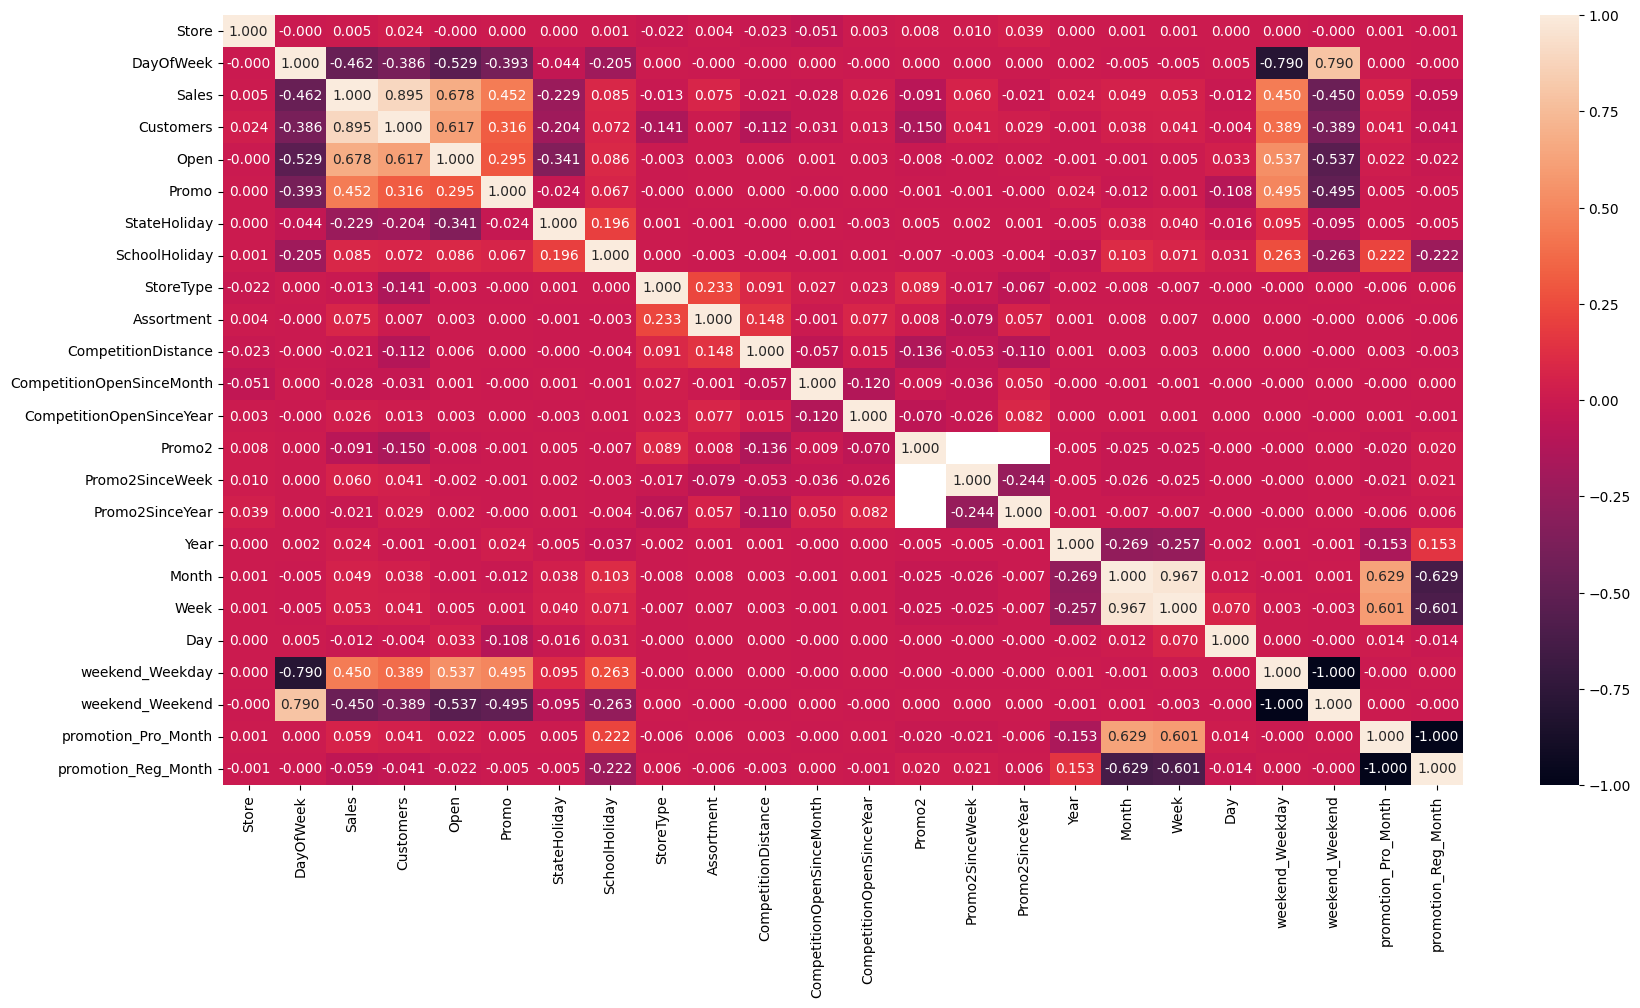

In [14]:
import seaborn as sns
plt.figure(figsize = (20, 10))

sns.heatmap(data.corr(), annot = True, vmin = -1, vmax = 1, fmt = '.3f')

In [15]:
data.columns

Index(['Date', 'Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Week', 'Day',
       'weekend_Weekday', 'weekend_Weekend', 'promotion_Pro_Month',
       'promotion_Reg_Month'],
      dtype='object')

In this step, the data is split into train, test, and validation sets using time-based split method. This method is particularly useful when there is a clear temporal component to the data, such as sales data where you want to evaluate the model's ability to make predictions on future data.

In [16]:
# b) Split the data into training, test, and validation sets
train = data[:int(len(data) * 0.7)]
test = data[int(len(data) * 0.7):int(len(data) * 0.9)]
validation = data[int(len(data) * 0.9):]
print(train.shape, test.shape, validation.shape)

X_train = train.drop(columns=['Sales', 'Store', 'Date', 'CompetitionOpenSinceMonth', 'Promo2SinceYear', 'PromoInterval'], axis = 1)
X_test = test.drop(columns=['Sales', 'Store', 'Date', 'CompetitionOpenSinceMonth', 'Promo2SinceYear', 'PromoInterval'], axis = 1)
X_val = validation.drop(columns=['Sales', 'Store', 'Date', 'CompetitionOpenSinceMonth', 'Promo2SinceYear', 'PromoInterval'], axis = 1)
y_val = validation['Sales']

(712046, 26) (203442, 26) (101721, 26)


Data needs to be stationary in LSTM models because a key assumption in time series analysis and modeling is that the underlying process generating the data is stationary, meaning that its statistical properties (such as mean and variance) remain constant over time. Stationary data also helps in removing trends and seasonality from the time series,  which are typically not of interest when modeling and making predictions.

In [17]:
y_train_ori = train['Sales']
y_test_ori = test['Sales']

# There are a number of methods to make data stationary in time: difference, log/squared root transform, 
# decomposition, and ARIMA. Here I use the squared root transformation considering broad range of data.
train.loc[:, 'Sales_sqrt'] = np.sqrt(y_train_ori)
test.loc[:, 'Sales_sqrt']  = np.sqrt(y_test_ori)

# Now we can use Sales_sqrt as a new target for training and validation
y_train = train['Sales_sqrt']
y_test = test['Sales_sqrt']

In [18]:
# c) Data Transforms
# Standardize the dataset by rescaling the distribution of values 

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_val = scaler.fit_transform(X_val)

# convert the array back to a dataframe
X_train = DataFrame(X_train)
X_test = DataFrame(X_test)
X_val = DataFrame(X_val)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(712046, 20) (203442, 20)
(712046,) (203442,)


**4. Evaluate Algorithms**

In [19]:
# Define baseline mean_absolute_error of y_test and y in the data set
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
# math.sqrt(mean_squared_error(y_train,train_predict))

y_mean = np.mean(y_temp)
y_mean = np.array([y_mean]*len(y_test))
mae_ori = mean_absolute_error(y_test**2, y_mean)
print("Mean Absolute Error of original data: ", mae_ori)

Mean Absolute Error of original data:  2822.964400997831


In [20]:
# Function to convert an array into a input tensor for LSTM. Note that lookback window determines 
# how far back in time (number of previous time steps) the model considers when making a prediction.
def create_tensor(data, lookback):
    X = []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
    return np.array(X)

In [21]:
# Convert the training, testing, and validation arrays into input tensors [samples, timesteps, features]
# for LSTM model. Here I select 7 days lookback to capture sales data changes in weekly basis.
lookback = 7
X_train = create_tensor(X_train, lookback)
X_test = create_tensor(X_test, lookback)
X_val = create_tensor(X_val, lookback)
y_train = y_train[lookback:]
y_test = y_test[lookback:]
y_val = y_val[lookback:]

In [22]:
# build the LSTM model
# This kind of neural network model is susceptible to overfitting, so incorporating BatchNormalization
# and Dropout layers can aid in stabilizing and enhancing the model's performance.
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(BatchNormalization()),
model.add(Dropout(0.3))
model.add(Dense(128))
model.add(BatchNormalization()),
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [25]:
data.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceYear,PromoInterval,Year,Month,Week,Day,weekend_Weekday,weekend_Weekend,promotion_Pro_Month,promotion_Reg_Month
0,2015-07-31,11,5,5263,555,1,1,0,1,3,...,NaN,NaN,2015,7,31,31,1,0,1,0
1,2015-07-30,11,4,5020,546,1,1,0,1,3,...,NaN,NaN,2015,7,31,30,1,0,1,0
2,2015-07-29,11,3,4782,523,1,1,0,1,3,...,NaN,NaN,2015,7,31,29,1,0,1,0
3,2015-07-28,11,2,5011,560,1,1,0,1,3,...,NaN,NaN,2015,7,31,28,1,0,1,0
4,2015-07-27,11,1,6102,612,1,1,0,1,3,...,NaN,NaN,2015,7,31,27,1,0,1,0


In [29]:
data.sort_values(by='Date', ascending=False)
data

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceYear,PromoInterval,Year,Month,Week,Day,weekend_Weekday,weekend_Weekend,promotion_Pro_Month,promotion_Reg_Month
0,2015-07-31,11,5,5263,555,1,1,0,1,3,...,NaN,NaN,2015,7,31,31,1,0,1,0
1,2015-07-30,11,4,5020,546,1,1,0,1,3,...,NaN,NaN,2015,7,31,30,1,0,1,0
2,2015-07-29,11,3,4782,523,1,1,0,1,3,...,NaN,NaN,2015,7,31,29,1,0,1,0
3,2015-07-28,11,2,5011,560,1,1,0,1,3,...,NaN,NaN,2015,7,31,28,1,0,1,0
4,2015-07-27,11,1,6102,612,1,1,0,1,3,...,NaN,NaN,2015,7,31,27,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,2013-01-05,1104,6,4771,339,1,0,0,1,4,...,2012.0,"Mar,Jun,Sept,Dec",2013,1,1,5,0,1,0,1
1017205,2013-01-04,1104,5,4540,326,1,0,0,1,4,...,2012.0,"Mar,Jun,Sept,Dec",2013,1,1,4,1,0,0,1
1017206,2013-01-03,1104,4,4297,300,1,0,0,1,4,...,2012.0,"Mar,Jun,Sept,Dec",2013,1,1,3,1,0,0,1
1017207,2013-01-02,1104,3,3697,305,1,0,0,1,4,...,2012.0,"Mar,Jun,Sept,Dec",2013,1,1,2,1,0,0,1


In [23]:
# Define a callback for early stopping if the validation loss does not improve for 20 consecutive 
# epochs (patience=20).
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

In [24]:
# Fit the model to the training and testing data
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=2)

Epoch 1/50


KeyboardInterrupt: ignored

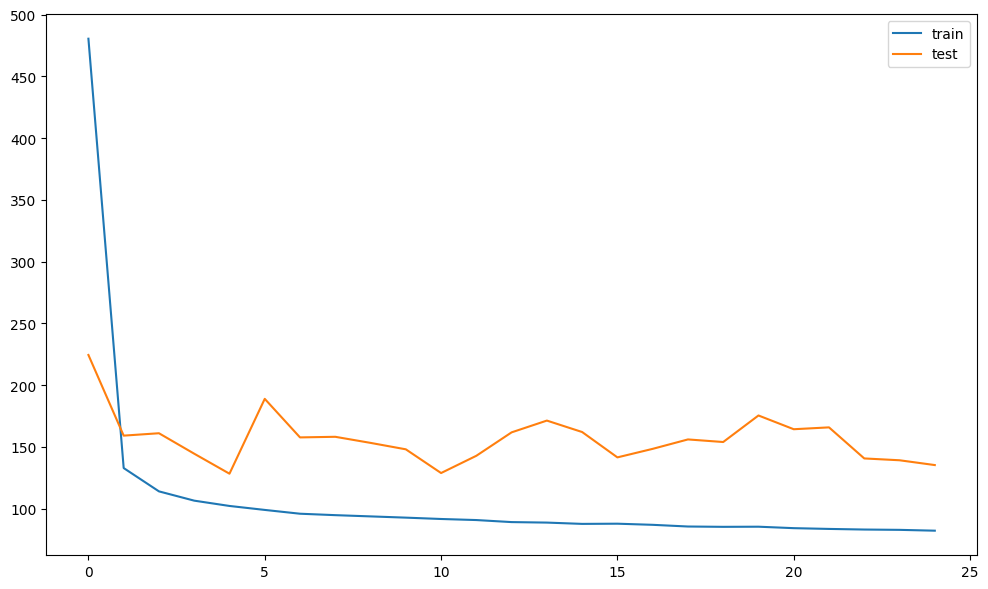

In [ ]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

**5. Finalize Model**

In [ ]:
# a) Predictions on validation dataset
y_pred = model.predict(X_val)

3179/3179 [==============================] - 10s 3ms/step


In [ ]:
# Calculate mean_absolute_error of the prediction
y_pred_trans = y_pred**2 # Convert y_pred back to original data format
mae_pred = mean_absolute_error(y_val, y_pred_trans)
print("Mean Absolute Error of predicted data: ", mae_pred)

Mean Absolute Error of predicted data:  971.1930992732451


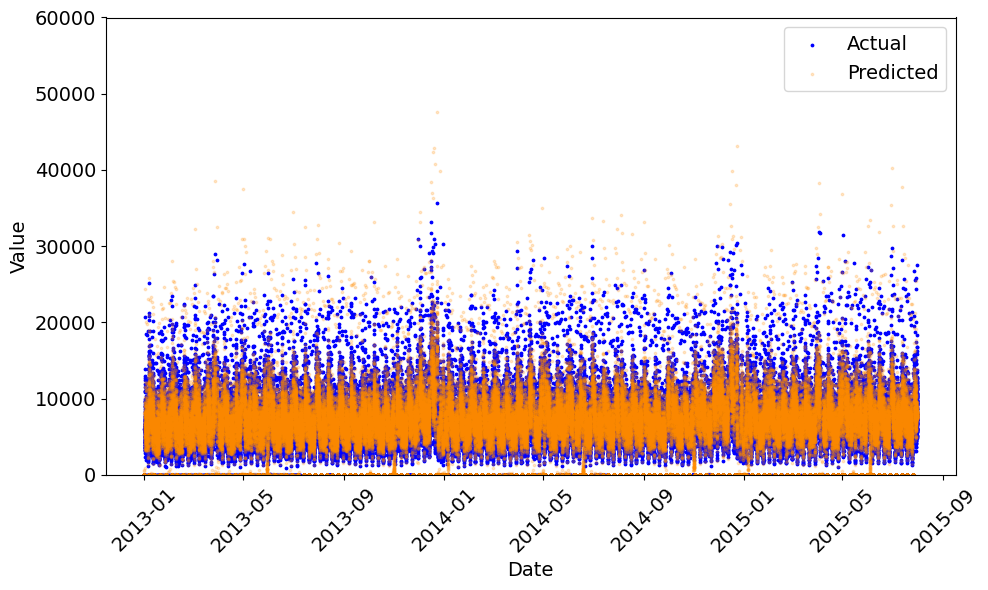

In [ ]:
# Create a scatter plot of predicted and actual sales data
# remove the first 7 days of validation['Date'] to match the shape of y_pred_trans and y_val
dates = validation['Date'][7:]

# set the width of the scatter points
scatter_size = 3

# create a figure and axis object
fig, ax = plt.subplots()
ax.set_ylim(top=60000)

# plot the actual data as blue scatter points
ax.scatter(dates, y_val, s=scatter_size, label='Actual', color='blue')

# plot the predicted data as dark orange scatter points with lower opacity
ax.scatter(dates, y_pred_trans, s=scatter_size, label='Predicted', color='darkorange', alpha=0.2)

# add labels and legend
plt.xlabel("Date", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(fontsize=14)

# set tick font size for both axes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# rotate the x-axis labels by 45 degrees for better visibility
plt.xticks(rotation=45)

# show the plot
plt.show()